# <center>Welcome to oLIMpus Tutorial #2!</center>
### <center>By S. Libanore</center>
oLIMpus is based on a fully analytical effective model, and it allows to produce and study LIM auto- and cross- power spectra durning the EoR. 

Our work builds on the 21-cm effective model presented in Zeus21 (Munoz 2023), which is contained as a submodule of our package.

#### In this notebook you will learn how to...
- create mock coeval boxes 
- create lightcones 

#### Available quantites:
- $\delta$ density
- SFRD (cell-by-cell computation)
- $\rho_L$ luminosity density (cell-by-cell computation)
- $x_{\rm HI}$ field (cell-by-cell computation)
- $T_{21}$ brightness temperature 
- $I_\nu$ star-forming line intensity (analytical or cell-by-cell computation)

## General definitions

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import os 
import pickle

Set the inputs based on the **analysis.py** module. 

To get familiar with it, check Tutorial #1!

In [3]:
import oLIMpus.analysis as a 

# CLASS object 
ClassyC = a.runclass(a.Cosmo_Parameters_Input(**a.CosmoParams_input_fid))

# oLIMpus object containing 21cm and OIII properties
OIII_model = a.run_oLIMpus('OIII',LINE_MODEL = 'Yang24', _R = 1., shot_noise= True, quadratic_lognormal=True, astromodel=0, ZMIN=5., RSD_MODE=1)

/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:28: RuntimeWarning: divide by zero encountered in power
  L_line = 2. * N * dotM / ((dotM / SFR1)**(-alpha) + (dotM / SFR1)**beta)
/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:30: RuntimeWarning: divide by zero encountered in log10
  log10_L = np.log10(L_line)


Import the relevant functions from the **maps_LIM** module.

oLIMpus provides three ways to produce mock coeval boxes:

#### CoevalBox_LIM_analytical
Relies on the analytical power spectra computed either from cosmology or using our formalism.

Use it for:
- density $\leftrightarrow P_m(k,z)$
- star-forming line intensity (with /without shot noise, with/without RSD) $\leftrightarrow P_\nu(k,z),\, {\rm RSD}(k,z), P_{\rm shot}(z)$

All outputs can be smoothed over the input $R_0$ using a real space top hat window function. 

#### CoevalBox_percell
Computes density-weighted quantities based on the EPS formalism in Eulerian space. 

Use it for:
- density $\leftrightarrow P_m(k,z)$
- SFRD $\to {\rm SFRD}(\vec{x},z) = (1+\delta(\vec{x},z))\int dM_h dn/dM_h C_{\rm EPS}\dot{M}_*(M_h)$
- luminosity density $\to {\rho}_L(\vec{x},z) = (1+\delta(\vec{x},z))\int dM_h dn/dM_h C_{\rm EPS}L(M_h)$
- star-forming line intensity $\to I_\nu(\vec{x},z)\propto\bar{I}_\nu(z)\bar\rho_L(\vec{x},z)/\bar{\rho}_L$ 

#### CoevalBox_T21reionization
Inherited from Zeus21, computes the $T_{21}(\vec{x},z)$ brightness temperature based on the effective analytical model. 

Computes the ionization field $x_{\rm HII}(\vec{x},z)$ cell-by-cell based on barrier crossing formalism, transforms it to $x_{\rm HI}$ and use it to produce the bubble field and scale $T_{21}(\vec{x},z)$ during the EoR. A fully analytical computation of the bubble field will be provided in next releases. 

Use it for:
- $x_{HI}(\vec{x},z)$
- $T_{21}(\vec{x},z)$

In [8]:
from oLIMpus import CoevalBox_T21reionization, CoevalBox_percell, CoevalBox_LIM_analytical, get_reio_field
from oLIMpus import eor_colour, LIM_colour_1

## Produce mock coeval boxes

The following function computes the coeval boxes for the input quantity; it also allows the user to save-and-import it to prevent the need of re-computing everything from scratch (note that only 1 slice is stored, for memory reason). 

The smooth and shot noise flags only refer to the LIM case, while RSD can also be introduced in the 21-cm brightness temperature map. 

In [22]:
def get_box_slice(which_box, z, Lbox, Nbox, line_model, ClassyC, smooth, shot_noise, seed, save_and_import):

    # which slice in the box is used
    _islice = 0

    if save_and_import:

        # folder and file name to store the slice
        folder = './boxes_' + str(Lbox) + ',' + str(Nbox)
        if not os.path.exists(folder):
            os.makedirs(folder)
        if which_box == 'LIM':
            filename_all = folder + '/' + which_box  + '_' + line_model.LP.LINE + '_z' + str(round(z,1))+ '.pkl'    
        else:
            filename_all = folder + '/' + which_box + '_z' + str(round(z,1))+ '.pkl'

        # import the slice if previously run
        if os.path.exists(filename_all):
            with open(filename_all, 'rb') as handle:
                slice = pickle.load(handle)

    # run oLIMpus 
    else:
        if which_box == 'density' or which_box == 'LIM':
            all_boxes = CoevalBox_LIM_analytical(line_model.LIM_coeff,line_model.LIM_corr,line_model.LIM_pk,line_model.LP,z,line_model.LP._R,Lbox,Nbox, RSD=1, get_density_box=True)
            if which_box == 'density':
                box = all_boxes.density_box
            else:
                if smooth:
                    if shot_noise:
                        box = all_boxes.Inu_box_smooth
                    else:
                        box = all_boxes.Inu_box_noiseless_smooth
                else:
                    if shot_noise:
                        box = all_boxes.Inu_box
                    else:
                        box = all_boxes.Inu_box_noiseless

        elif which_box == 'T21' or which_box == 'xHI':
            # reionization library, create bubble field
            reionization_map_partial, ion_frac_withpartial = get_reio_field(line_model.zeus_coeff, line_model.zeus_corr, line_model.AP, line_model.CP, ClassyC, line_model.HMFcl, Lbox, Nbox, seed, mass_weighted_xHII=True,one_slice=False)

            all_boxes = CoevalBox_T21reionization(line_model.zeus_coeff, line_model.zeus_pk,z, reionization_map_partial, ion_frac_withpartial, Lbox,Nbox, seed=seed)
            if which_box == 'T21':
                box = all_boxes.T21_map
            else:
                box = all_boxes.xH_box

        elif which_box == 'SFRD' or which_box == 'rhoL':
            all_boxes = CoevalBox_percell(line_model.LIM_coeff,line_model.LIM_corr,line_model.LIM_pk,line_model.zeus_coeff, line_model.LP,line_model.AP,line_model.CP,line_model.HMFcl,z,line_model.LP._R,Lbox,Nbox)
            if which_box == 'SFRD':
                box = all_boxes.SFRD_box
            else:
                if smooth:
                    box = all_boxes.rhoL_box_smooth
                else:
                    box = all_boxes.rhoL_box
        else:
            print('Check input box.')
            return -1
        
        slice = box[_islice]

        # save the slice if required
        if save_and_import:
            with open(filename_all, 'wb') as handle:
                pickle.dump(slice,handle)

    return slice


The following function plots all the relevant boxes, in a 2x3 configuration. The user can personalize this function to produce the plot of their interest.

In [25]:
def plot_slices(z, Lbox, Nbox, line_model, ClassyC, smooth, seed, save_and_import):

    # setup quantities for the plot 
    boxes = ['density', 
             'SFRD', 
             'xHI', 
             'T21', 
             'LIM', 
             'LIM']
    title = [r'$\delta$', 
             r'${\rm SFRD}\,[M_\odot/{\rm yr}/{\rm Mpc^3}]$',
             r'$x_{\rm HI}$',
             r'$T_{21}\,[{\rm mK}]$',
            r'$I_{\rm %s}\,[{\rm Jy/sr}]$'%line_model.LP.LINE,
            r'$I_{\rm %s}+{\rm shot\,noise}$'%line_model.LP.LINE]
    cmap = ['magma', 
            'bwr', 
            'gray',
            eor_colour, # colormap defined in mapsLIM
            LIM_colour_1,# colormap defined in mapsLIM
            LIM_colour_1] # colormap defined in mapsLIM
    vmin = [-0.6,
            1e-3,
            0,
            -50,
            0.,
            0.]
    vmax = [0.6,
            1e0,
            1,
            40,
            None,
            None]

    # size figure
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(7, 4))
    subpl = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]

    # plot each quantity
    for i in range(len(boxes)):
        shot_noise = True if i == len(boxes)-1 else False
        slice = get_box_slice(boxes[i], z, Lbox, Nbox, line_model, ClassyC, smooth, shot_noise, seed, save_and_import)
    
        if vmax[i] == None:
            vmax[i] = 0.65*np.max(slice)

        if cmap[i] == 'bwr':
            im = ax[subpl[i]].imshow(slice,extent=(0,Lbox,0,Lbox),cmap=cmap[i],norm = LogNorm(vmin=vmin[i], vmax=vmax[i]))
            xticks = [1e-3, 1e-2, 1e-1,1]  
        else:
            im = ax[subpl[i]].imshow(slice,extent=(0,Lbox,0,Lbox),cmap=cmap[i],vmax =vmax[i], vmin = vmin[i])
            xticks = np.linspace(vmin[i],vmax[i],4)

        cbar = fig.colorbar(im, ax=ax[subpl[i]], fraction=0.046, pad=0.04, format="%.0e")

        array_ticks = np.vectorize(lambda x: f"{x:.0e}")(xticks)

        cbar.set_ticks(xticks, labels = array_ticks)

        ax[subpl[i]].text(
            0.05, 0.05, title[i], 
            color='black',
            fontsize=10,
            ha='left', va='bottom',
            transform=ax[subpl[i]].transAxes,  
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')  
        )
        ax[subpl[i]].set_xticks([])
        ax[subpl[i]].set_yticks([])

    fig.suptitle(r'$z = %g$'%round(z,1), fontsize=15)

    # save the figure if required
    if save_and_import:
        fig.subplots_adjust(left=0.05, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
        plt.savefig('./oLIMpus_all_boxes_' + str(Lbox) + ',' + str(Nbox) + '.png',dpi=500,bbox_inches='tight')

    plt.show()
    
    return 

#### Example: plot density, SFRD, $x_{\rm HI}$, $T_{21}$, $I_{\rm OIII}$

To produce the plot you need to set the size of the box $L_{\rm box}$ and the number of cells $N_{\rm box}$. The largest scale accessed in the box is $k_{\rm min}=2\pi/L_{\rm box},$ while the smallest is $k_{\rm max}=2\pi N_{\rm box}/L_{\rm box}.$ Remember that the computational power of the run depends on $N_{\rm box}$.

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 2.0
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 2.0
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 2.0


/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:28: RuntimeWarning: divide by zero encountered in power
  L_line = 2. * N * dotM / ((dotM / SFR1)**(-alpha) + (dotM / SFR1)**beta)
/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:30: RuntimeWarning: divide by zero encountered in log10
  log10_L = np.log10(L_line)
 60%|██████    | 6/10 [00:00<00:00,  7.11it/s]


SUCCESS: BMF converged in 6 iterations.


 60%|██████    | 6/10 [00:00<00:00,  7.98it/s]


SUCCESS: BMF converged in 6 iterations.


100%|██████████| 99/99 [00:24<00:00,  3.97it/s]


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 2.0
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 2.0


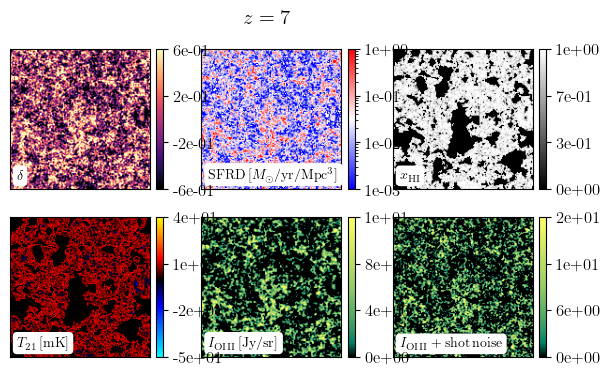

In [26]:
Lbox_fid = 300 
Nbox_fid = 150 
z = 7.

plot_slices(z, Lbox_fid, Nbox_fid, OIII_model, ClassyC, smooth=True,seed=1605, save_and_import=False)

You can also estimate the auto- and cross- power spectra from the LIM boxes. To do so, we use the publicly available code **powerbox**.

In [27]:
import powerbox as pb

In [28]:
# we introduce a second line, with a different resolution for illustration purposes
CO_model = a.run_oLIMpus('CO',LINE_MODEL = 'Yang21', _R = 5., shot_noise= True, quadratic_lognormal=True, astromodel=0, ZMIN=5., RSD_MODE=1)

UnboundLocalError: local variable 'lambda_line' referenced before assignment

In [ ]:
k_bins = np.logspace(np.log10(2*np.pi/Lbox_fid),np.log10(2*np.pi/Lbox_fid*Nbox_fid),10) # define the k array 

# get boxes for two different line
slice_LIM = get_box_slice('LIM', z, Lbox_fid, Nbox_fid, OIII_model, ClassyC, smooth=False, shot_noise=True, save_and_import=False)
slice_LIM_1 = get_box_slice('LIM', z, Lbox_fid, Nbox_fid, CO_model, ClassyC, smooth=False, shot_noise=True, save_and_import=False)

# compute the LIM power spectrum 
pk_LIM, k_LIM = pb.get_power(
    deltax = slice_LIM,
    boxlength= Lbox_fid,
    bins = k_bins
    )

# compute the LIM power spectrum for the second line
pk_LIM_1, k_LIM_1 = pb.get_power(
    deltax = slice_LIM_1,
    boxlength= Lbox_fid,
    bins = k_bins
    )

# compute the cross power spectrum 
pk_cross, k_cross = pb.get_power(
    deltax = slice_LIM,
    boxlength= Lbox_fid,
    deltax2 = slice_LIM_1,
    bins = k_bins
    )


We compare the auto-power spectra estimated from the boxes with the analytical ones obtained using the effective models of oLIMpus (see tutorial #1).

In the following plot we scale the auto- power spectra by the average mean of each signal. 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8.5, 3.7),)

axes[0].loglog(klist,OIII_model.LIM_pk.Deltasq_LIM[iz_val_0]/OIII_model.LIM_coeff.Inu_bar[iz_val_0]**2,color=a.colors[0],label=r'${\rm OIII},\,R_0=%g\,{\rm Mpc}$'%OIII_model.LP._R,)
axes[0].loglog(klist,CO_model.Deltasq_LIM[iz_val_0]/CO_model.Inu_bar[iz_val_0]**2,color=a.colors[3],label=r'${\rm H\alpha},\,R_0=%g\,{\rm Mpc}$'%CO_model.LP._R,)

axes[0].scatter(k_LIM,pk_LIM[0]*(k_LIM**3/(2*np.pi**2))/OIII_model.LIM_coeff.Inu_bar[iz_val_0]**2,color=a.colors[0],marker='o',zorder=8,)
axes[0].scatter(k_LIM_1,pk_LIM_1*(k_LIM_1**3/(2*np.pi**2))/CO_model.Inu_bar[iz_val_0]**2,color=a.colors[3],marker='o',zorder=8,)

axes[0].set_ylabel(r'${\Delta^2_{\nu}(k,z)}/{\bar{I}_\nu^2(z)}$',fontsize=15)
axes[0].set_xlabel(r'$k\,[{\rm Mpc^{-3}}]$',fontsize=15)
axes[0].legend(fontsize=13,columnspacing=0.5,loc=4,ncol=1)


axes[1].loglog(klist,LIM_pk_cross_OIIICO.Deltasq_LIM[iz_val_0],color=a.colors[5],label=r'${\rm OIII\times CO}$',)

axes[1].scatter(k_cross,pk_cross*(k_cross**3/(2*np.pi**2)),color=a.colors[5],marker='o',zorder=8,)

axes[1].set_ylabel(r'$\Delta^2_{\nu_1,\nu_2}(k,z)\,[{\rm Jy^2/sr^2}]$',fontsize=15)
axes[1].set_xlabel(r'$k\,[{\rm Mpc^{-3}}]$',fontsize=15)
axes[1].legend(fontsize=13,columnspacing=0.5,loc=4,ncol=1)

axes[0].set_title(r'$z=%g$'%round(LIM_coeff_CII.zintegral[iz_val_0],1),fontsize=15)
axes[1].set_title(r'$z=%g$'%round(LIM_coeff_CII.zintegral[iz_val_0],1),fontsize=15)
axes[0].set_ylim(8e-6,5)
axes[1].set_ylim(1e-3,5e7)

axes[0].set_xlim(4e-3,1.5)
axes[1].set_xlim(4e-3,1.5)

plt.tight_layout()


## Plot lightcones

In [29]:
from oLIMpus import plot_lightcone

/mnt/DATA/coding/21cm/oLIMpus/Tutorial/analysis_200,150,1.0/lightconesdensity.pkl
Running lightcone...


 60%|██████    | 6/10 [00:01<00:00,  5.66it/s]


SUCCESS: BMF converged in 6 iterations.


  0%|          | 0/100 [00:00<?, ?it/s]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


  1%|          | 1/100 [00:03<05:40,  3.44s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


  2%|▏         | 2/100 [00:06<05:40,  3.47s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


  3%|▎         | 3/100 [00:10<05:50,  3.61s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


  4%|▍         | 4/100 [00:14<05:40,  3.55s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


  5%|▌         | 5/100 [00:17<05:28,  3.45s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


  6%|▌         | 6/100 [00:20<05:21,  3.42s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


  7%|▋         | 7/100 [00:24<05:14,  3.38s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


  8%|▊         | 8/100 [00:27<05:08,  3.35s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


  9%|▉         | 9/100 [00:30<05:05,  3.35s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 10%|█         | 10/100 [00:34<04:59,  3.33s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 11%|█         | 11/100 [00:37<04:54,  3.31s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 12%|█▏        | 12/100 [00:40<04:50,  3.30s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 13%|█▎        | 13/100 [00:43<04:45,  3.28s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 14%|█▍        | 14/100 [00:47<04:43,  3.30s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 15%|█▌        | 15/100 [00:50<04:48,  3.40s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 16%|█▌        | 16/100 [00:54<04:46,  3.41s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 17%|█▋        | 17/100 [00:57<04:39,  3.37s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 18%|█▊        | 18/100 [01:00<04:35,  3.36s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 19%|█▉        | 19/100 [01:04<04:30,  3.34s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 20%|██        | 20/100 [01:07<04:25,  3.32s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 21%|██        | 21/100 [01:10<04:20,  3.30s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 22%|██▏       | 22/100 [01:13<04:17,  3.30s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 23%|██▎       | 23/100 [01:17<04:12,  3.27s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 24%|██▍       | 24/100 [01:20<04:10,  3.29s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 25%|██▌       | 25/100 [01:23<04:07,  3.31s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 26%|██▌       | 26/100 [01:27<04:03,  3.29s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 27%|██▋       | 27/100 [01:30<04:01,  3.31s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 28%|██▊       | 28/100 [01:33<03:57,  3.30s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 29%|██▉       | 29/100 [01:37<03:55,  3.32s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 30%|███       | 30/100 [01:40<03:52,  3.33s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 31%|███       | 31/100 [01:43<03:53,  3.39s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 32%|███▏      | 32/100 [01:47<03:52,  3.42s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 33%|███▎      | 33/100 [01:50<03:49,  3.43s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 34%|███▍      | 34/100 [01:54<03:49,  3.48s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 35%|███▌      | 35/100 [01:58<03:49,  3.53s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 36%|███▌      | 36/100 [02:01<03:45,  3.52s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 37%|███▋      | 37/100 [02:05<03:39,  3.48s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 38%|███▊      | 38/100 [02:08<03:34,  3.46s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 39%|███▉      | 39/100 [02:11<03:29,  3.43s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 40%|████      | 40/100 [02:15<03:23,  3.40s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 41%|████      | 41/100 [02:18<03:22,  3.44s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 42%|████▏     | 42/100 [02:22<03:22,  3.49s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 43%|████▎     | 43/100 [02:25<03:22,  3.55s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 44%|████▍     | 44/100 [02:29<03:19,  3.56s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 45%|████▌     | 45/100 [02:33<03:17,  3.59s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 46%|████▌     | 46/100 [02:36<03:13,  3.57s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 47%|████▋     | 47/100 [02:40<03:07,  3.53s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 48%|████▊     | 48/100 [02:43<03:03,  3.53s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 49%|████▉     | 49/100 [02:47<02:58,  3.50s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 50%|█████     | 50/100 [02:50<02:56,  3.54s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 51%|█████     | 51/100 [02:54<02:53,  3.53s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 52%|█████▏    | 52/100 [02:57<02:49,  3.53s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 53%|█████▎    | 53/100 [03:01<02:44,  3.50s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 54%|█████▍    | 54/100 [03:04<02:37,  3.43s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 55%|█████▌    | 55/100 [03:07<02:32,  3.38s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 56%|█████▌    | 56/100 [03:11<02:28,  3.37s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 57%|█████▋    | 57/100 [03:14<02:25,  3.38s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 58%|█████▊    | 58/100 [03:17<02:22,  3.39s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 59%|█████▉    | 59/100 [03:21<02:21,  3.46s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 60%|██████    | 60/100 [03:25<02:19,  3.49s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 61%|██████    | 61/100 [03:28<02:17,  3.54s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 62%|██████▏   | 62/100 [03:32<02:14,  3.53s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 63%|██████▎   | 63/100 [03:35<02:09,  3.50s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 64%|██████▍   | 64/100 [03:39<02:06,  3.51s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 65%|██████▌   | 65/100 [03:42<02:05,  3.58s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 66%|██████▌   | 66/100 [03:46<02:00,  3.54s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 67%|██████▋   | 67/100 [03:49<01:55,  3.50s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 68%|██████▊   | 68/100 [03:53<01:51,  3.47s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 69%|██████▉   | 69/100 [03:56<01:48,  3.50s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 70%|███████   | 70/100 [04:00<01:47,  3.59s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 71%|███████   | 71/100 [04:04<01:43,  3.58s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 72%|███████▏  | 72/100 [04:07<01:39,  3.55s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 73%|███████▎  | 73/100 [04:11<01:35,  3.55s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 74%|███████▍  | 74/100 [04:14<01:31,  3.52s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 75%|███████▌  | 75/100 [04:18<01:28,  3.53s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 76%|███████▌  | 76/100 [04:21<01:23,  3.49s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 77%|███████▋  | 77/100 [04:25<01:19,  3.48s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 78%|███████▊  | 78/100 [04:28<01:16,  3.49s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 79%|███████▉  | 79/100 [04:31<01:12,  3.45s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 80%|████████  | 80/100 [04:35<01:08,  3.42s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 81%|████████  | 81/100 [04:38<01:05,  3.44s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 82%|████████▏ | 82/100 [04:42<01:02,  3.45s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 83%|████████▎ | 83/100 [04:45<00:58,  3.46s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 84%|████████▍ | 84/100 [04:49<00:55,  3.44s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 85%|████████▌ | 85/100 [04:52<00:51,  3.46s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 86%|████████▌ | 86/100 [04:56<00:48,  3.44s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 87%|████████▋ | 87/100 [04:59<00:45,  3.48s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 88%|████████▊ | 88/100 [05:03<00:41,  3.47s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 89%|████████▉ | 89/100 [05:06<00:38,  3.51s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 90%|█████████ | 90/100 [05:10<00:34,  3.49s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 91%|█████████ | 91/100 [05:13<00:31,  3.55s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 92%|█████████▏| 92/100 [05:17<00:28,  3.56s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 93%|█████████▎| 93/100 [05:21<00:25,  3.61s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 94%|█████████▍| 94/100 [05:24<00:21,  3.57s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 95%|█████████▌| 95/100 [05:27<00:17,  3.53s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 96%|█████████▌| 96/100 [05:31<00:14,  3.53s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 97%|█████████▋| 97/100 [05:35<00:10,  3.55s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 98%|█████████▊| 98/100 [05:38<00:07,  3.55s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 99%|█████████▉| 99/100 [05:42<00:03,  3.53s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


100%|██████████| 100/100 [05:45<00:00,  3.46s/it]


/mnt/DATA/coding/21cm/oLIMpus/Tutorial/analysis_200,150,1.0/lightconesSFRD.pkl
Running lightcone...


 60%|██████    | 6/10 [00:00<00:00,  7.52it/s]


SUCCESS: BMF converged in 6 iterations.


  0%|          | 0/100 [00:00<?, ?it/s]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:28: RuntimeWarning: divide by zero encountered in power
  L_line = 2. * N * dotM / ((dotM / SFR1)**(-alpha) + (dotM / SFR1)**beta)
/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:30: RuntimeWarning: divide by zero encountered in log10
  log10_L = np.log10(L_line)
  1%|          | 1/100 [00:12<19:59, 12.12s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


  2%|▏         | 2/100 [00:23<19:23, 11.87s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


  3%|▎         | 3/100 [00:35<19:04, 11.80s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


  4%|▍         | 4/100 [00:47<18:52, 11.80s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


  5%|▌         | 5/100 [00:59<18:37, 11.76s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


  6%|▌         | 6/100 [01:11<18:43, 11.95s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


  7%|▋         | 7/100 [01:23<18:30, 11.94s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


  8%|▊         | 8/100 [01:35<18:22, 11.98s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


  9%|▉         | 9/100 [01:46<18:00, 11.88s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 10%|█         | 10/100 [01:58<17:39, 11.77s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 11%|█         | 11/100 [02:10<17:26, 11.75s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 12%|█▏        | 12/100 [02:22<17:16, 11.78s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 13%|█▎        | 13/100 [02:33<17:04, 11.77s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 14%|█▍        | 14/100 [02:45<16:54, 11.80s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 15%|█▌        | 15/100 [02:56<16:30, 11.65s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 16%|█▌        | 16/100 [03:08<16:07, 11.52s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 17%|█▋        | 17/100 [03:21<16:31, 11.94s/it]

The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 1.3333333333333333


 17%|█▋        | 17/100 [03:28<16:55, 12.24s/it]


KeyboardInterrupt: 

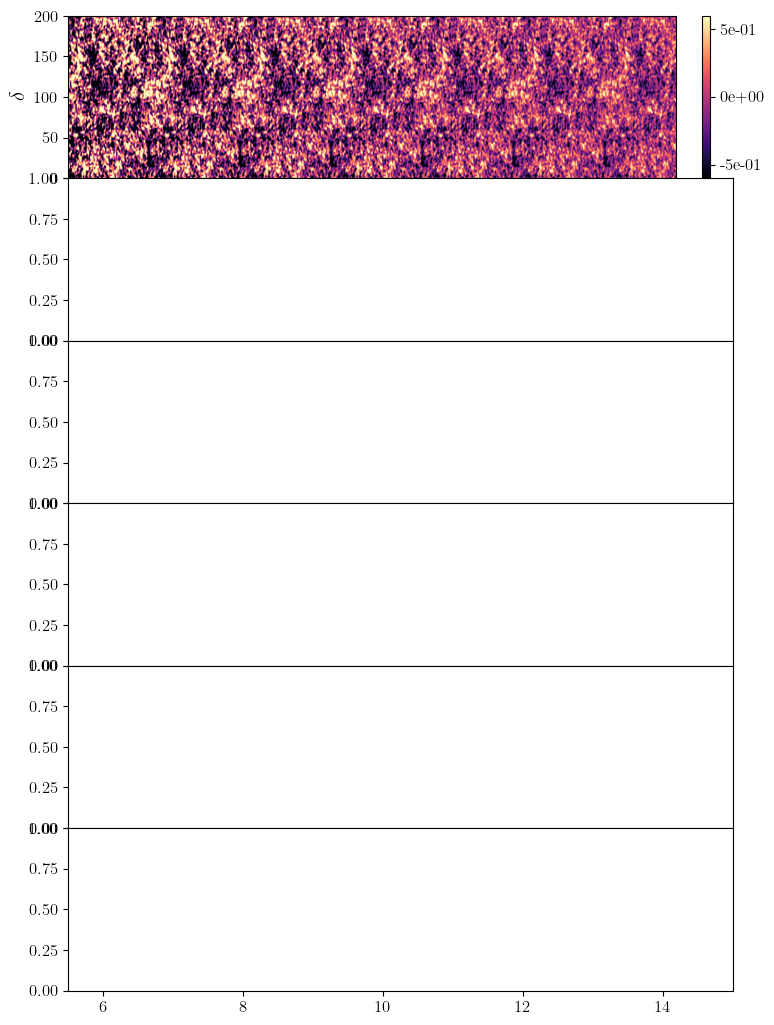

In [33]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(8,10.5),gridspec_kw={'hspace': 0},sharex=True)

plot_lightcone('density',
        np.logspace(np.log10(5.5),np.log10(15.),100)[::-1],
        Lbox = 200, 
        Ncell = 150, 
        R = 1.,
        seed = 1065, 
        analytical=True, 
        correlations_21 = OIII_model.zeus_corr,
        coefficients_21 = OIII_model.zeus_coeff,
        PS21 = OIII_model.zeus_pk,
        correlations = OIII_model.LIM_corr,
        coefficients = OIII_model.LIM_coeff,
        PSLIM = OIII_model.LIM_pk,
        mass_weighted_xHII=True,
        LineParams = OIII_model.LP,
        AstroParams=OIII_model.AP, 
        CosmoParams = OIII_model.CP,
        HMFintclass = OIII_model.HMFcl,
        ClassyCosmo=ClassyC,
        RSD = 1,
        fig=fig,
        ax=ax[0],
)

plot_lightcone('SFRD',
        np.logspace(np.log10(5.5),np.log10(15.),100)[::-1],
        200, 
        150, 
        1.,
        1065, 
        True, 
        OIII_model.zeus_corr,
        OIII_model.zeus_coeff,
        OIII_model.zeus_pk,
        OIII_model.LIM_corr,
        OIII_model.LIM_coeff,
        OIII_model.LIM_pk,
        True,
        OIII_model.LP,
        OIII_model.AP, 
        OIII_model.CP,
        OIII_model.HMFcl,
        ClassyC,
        1,
        fig=fig,
        ax=ax[1],
)
plot_lightcone('xHI',
        np.logspace(np.log10(5.5),np.log10(15.),100)[::-1],
        200, 
        150, 
        1.,
        1065, 
        True, 
        OIII_model.zeus_corr,
        OIII_model.zeus_coeff,
        OIII_model.zeus_pk,
        OIII_model.LIM_corr,
        OIII_model.LIM_coeff,
        OIII_model.LIM_pk,
        True,
        OIII_model.LP,
        OIII_model.AP, 
        OIII_model.CP,
        OIII_model.HMFcl,
        ClassyC,
        1,
        fig=fig,
        ax=ax[2],
)
plot_lightcone('T21',
        np.logspace(np.log10(5.5),np.log10(15.),100)[::-1],
        200, 
        150, 
        1.,
        1065, 
        True, 
        OIII_model.zeus_corr,
        OIII_model.zeus_coeff,
        OIII_model.zeus_pk,
        OIII_model.LIM_corr,
        OIII_model.LIM_coeff,
        OIII_model.LIM_pk,
        True,
        OIII_model.LP,
        OIII_model.AP, 
        OIII_model.CP,
        OIII_model.HMFcl,
        ClassyC,
        1,
        fig=fig,
        ax=ax[3],
)

plot_lightcone('LIM',
        np.logspace(np.log10(5.5),np.log10(15.),100)[::-1],
        200, 
        150, 
        1.,
        1065, 
        True, 
        OIII_model.zeus_corr,
        OIII_model.zeus_coeff,
        OIII_model.zeus_pk,
        OIII_model.LIM_corr,
        OIII_model.LIM_coeff,
        OIII_model.LIM_pk,
        True,
        OIII_model.LP,
        OIII_model.AP, 
        OIII_model.CP,
        OIII_model.HMFcl,
        ClassyC,
        1,
        fig=fig,
        ax=ax[4],
        RSD=1,
        include_label = 'OIII'
)


plt.tight_layout(h_pad=0.1)
plt.savefig('./lightcones_' + str(200) + ',' + str(200) + '.png',dpi=500,bbox_inches='tight')#,transparent=True)


In [11]:
2*np.pi/100

0.06283185307179587